In [ ]:
import os
import pandas as pd
import random
import shutil

data_path = r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\data\participants\1\extracted signals'   

In [2]:
os.chdir("..") 
from src import feature_extraction, models, utils, results

exclude = ['oral prep 0']
df, class_map = feature_extraction.make_df(data_path, exclude)

df

substance volume         1                                                \
                           min       max        mav        rms    wavelength   
0           0     10  -89.8215   73.5244  10.123081  15.526914   8511.370464   
1           0     10 -113.9200   86.1073   9.896790  16.791919   8262.519721   
2           0     10  -82.3953   84.7438  10.532140  16.572327   8938.223938   
3           0     10 -194.0030  125.6940  11.846242  20.842131   9634.231501   
4           0     10 -117.7260   84.5021  11.854229  18.994828   9543.440074   
..        ...    ...       ...       ...        ...        ...           ...   
440        10     20  -69.3289   69.5755  10.175371  15.426147   8874.451929   
441        10     20  -86.3076   74.0248  11.288252  18.020237   9792.563997   
442        10     20  -93.5527   91.9620  11.081596  17.163182   8838.968969   
443        10     20  -95.3684   61.4933  11.031382  16.758005   9634.328738   
444        10     20  -95.7571   91.9919  13.782139  20.737838  11234.928474   

                                                  ...       21     22         \
            var abs_diffs_signal shannon_entropy  ...     iemg    min    max   
0    241.085047      8511.370464        3.307889  ...  3186400 -15680  14560   
1    281.968302      8262.519721        2.937729  ...  4700640 -12740  12040   
2    274.641479      8938.223938        3.289639  ...  4222820 -13160  14560   
3    434.394440      9634.231501        2.507875  ...  4793600 -12740  22260   
4    360.801618      9543.440074        3.205701  ...  6150060 -14560  15400   
..          ...              ...             ...  ...      ...    ...    ...   
440  237.965865      8874.451929        3.528975  ...  3647980 -11620  18760   
441  324.728936      9792.563997        3.453142  ...  4262440 -23240  11200   
442  294.572930      8838.968969        3.245622  ...  4577440 -11060  13580   
443  280.830702      9634.328738        3.493063  ...  3906560 -15960  12040   
444  430.057924     11234.928474        3.549456  ...  4748940  -9800  14280   

                                                                     \
         mav          rms wavelength           var abs_diffs_signal   
0    3322.06  4634.416598     426580  2.147730e+07           426580   
1    4038.86  4996.715521     449540  2.476357e+07           449540   
2    4577.86  5597.687773     391580  3.078873e+07           391580   
3    5437.88  6691.171078     458780  4.119861e+07           458780   
4    5531.54  6675.993619     353780  4.449073e+07           353780   
..       ...          ...        ...           ...              ...   
440  3136.98  4313.488379     329560  1.854732e+07           329560   
441  3865.40  5367.578821     396620  2.879051e+07           396620   
442  4293.94  5302.465577     390740  2.811149e+07           390740   
443  3813.46  5118.934928     390040  2.616131e+07           390040   
444  3783.08  4801.379552     462560  2.290177e+07           462560   

                              
    shannon_entropy     iemg  
0          4.040291  3322060  
1          4.537548  4038860  
2          4.487950  4577860  
3          4.410476  5437880  
4          4.641191  5531540  
..              ...      ...  
440        3.997013  3136980  
441        4.062512  3865400  
442        4.641988  4293940  
443        4.344892  3813460  
444        4.518855  3783080  

[445 rows x 200 columns]

In [3]:
print(class_map)

{'apple': 0, 'carrot': 1, 'chewing': 2, 'dry swallow': 3, 'grape': 4, 'jelly': 5, 'milk': 6, 'popcorn': 7, 'redu oral prep': 8, 'water': 9, 'yogurt': 10}


# Configuration Classification

In [4]:
label_names = ['Substance', 'Volume']
imu_channels = [17, 18, 19, 20, 21, 22]

imu_acc_df = pd.read_csv('outputs/classification/imu_accuracies.csv', header=None)
imu_acc = imu_acc_df.iloc[0].tolist()

In [5]:
import matplotlib.pyplot as plt
import numpy as np

os.chdir("..") 
from src import feature_extraction, models, utils, results
from src.models import multioutput_models

model_names = [name for name, _ in multioutput_models]

def plot_config_acc(emg_imu_acc, emg_acc, imu_acc, config_name):
    x = np.arange(len(multioutput_models))  # [0, 1, 2]
    width = 0.25  # width of each bar

    # Plot bars side by side
    plt.bar(x - width, emg_imu_acc, width, label='Both EMG and IMU', color='dodgerblue')
    plt.bar(x, emg_acc, width, label='EMG only', color='deepskyblue')
    plt.bar(x + width, imu_acc, width, label='IMU only', color='lightskyblue')

    # Add labels
    plt.xticks(x, model_names, rotation=-45)
    plt.ylabel('Exact Accuracy (%)')
    plt.title(f'{config_name} Excluded')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()

def configuration_models(config_name, exclude_channels, see_metrics=False, cm=False):
    '''
    args:
        configuration (list): list of channels to drop
        cm (boolean): if True, plots confusion matrices
        print_metrics (boolean): if True, prints accuracy metrics per model
    '''
    # both emg + imu
    x = df.drop(columns=['volume', 'substance'] + exclude_channels)
    y = df[['substance', 'volume']]

    emg_imu_acc, emg_imu_label_acc = models.train_multioutput_models(x, y, 42, show_cm=cm)

    # only emg
    x = x.drop(columns=imu_channels)
    
    emg_acc, emg_label_acc = models.train_multioutput_models(x, y, 42, show_cm=cm)

    if see_metrics:
        print("---------------BOTH EMG AND IMU---------------")
        models.print_metrics(emg_imu_acc, emg_imu_label_acc)
        print("---------------ONLY EMG---------------")
        models.print_metrics(emg_acc, emg_label_acc)

    plot_config_acc(emg_imu_acc, emg_acc, imu_acc, config_name)

    return emg_imu_acc

C:\Users\chloe\AppData\Local\Temp\ipykernel_36104\3280705851.py:34: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


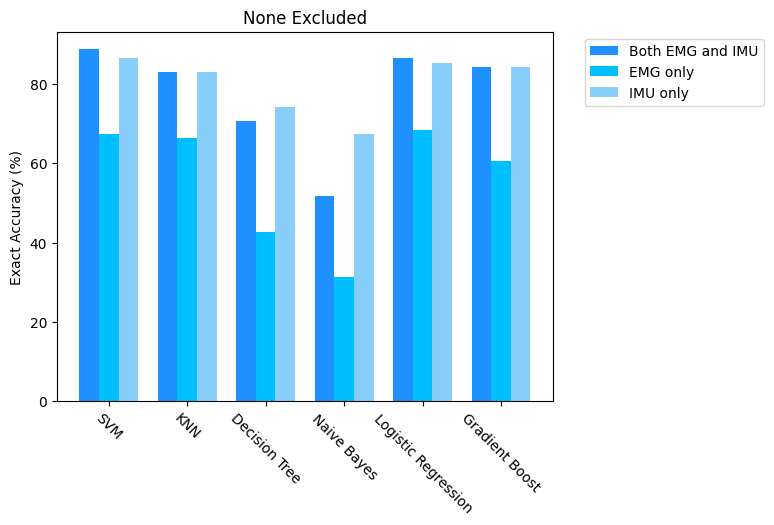

C:\Users\chloe\AppData\Local\Temp\ipykernel_36104\3280705851.py:34: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


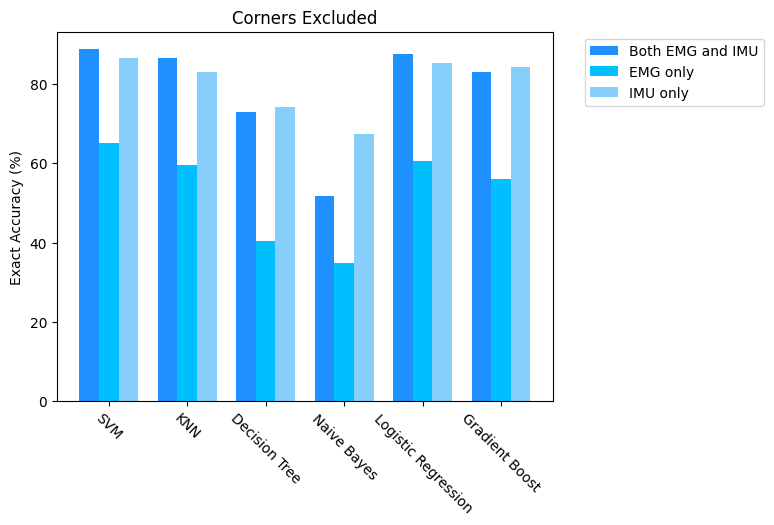

C:\Users\chloe\AppData\Local\Temp\ipykernel_36104\3280705851.py:34: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


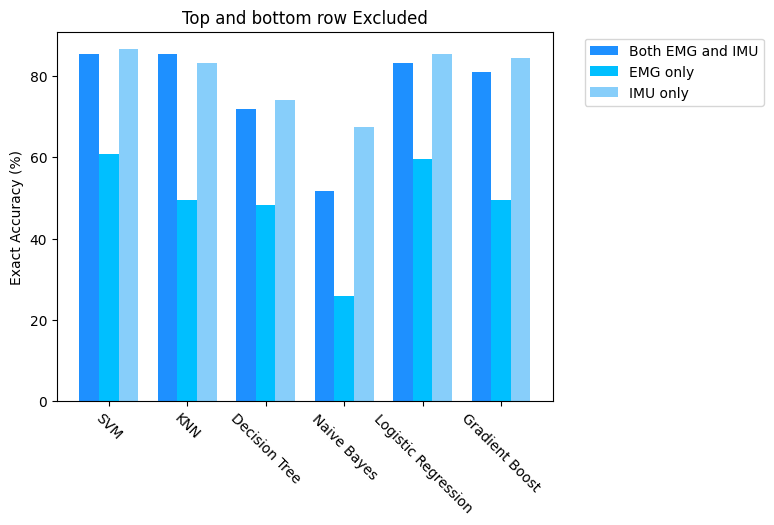

C:\Users\chloe\AppData\Local\Temp\ipykernel_36104\3280705851.py:34: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


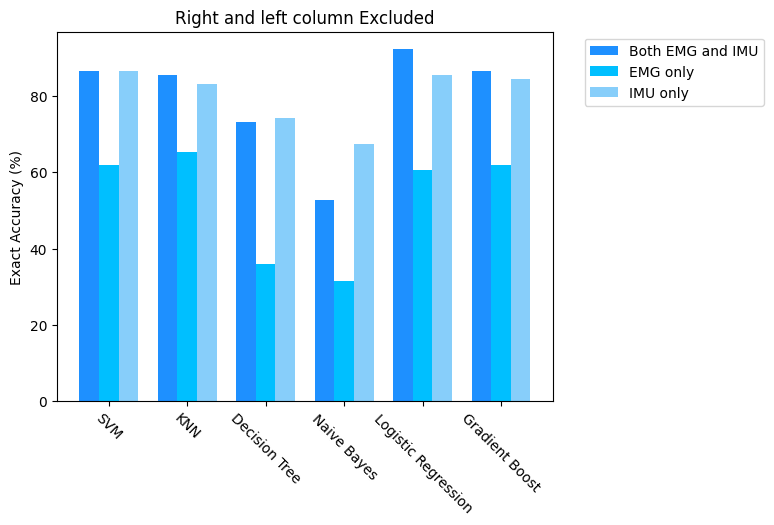

C:\Users\chloe\AppData\Local\Temp\ipykernel_36104\3280705851.py:34: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


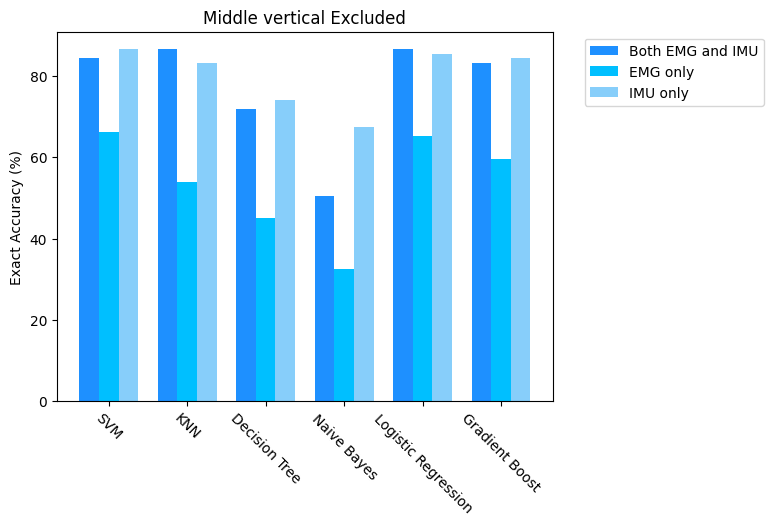

C:\Users\chloe\AppData\Local\Temp\ipykernel_36104\3280705851.py:34: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


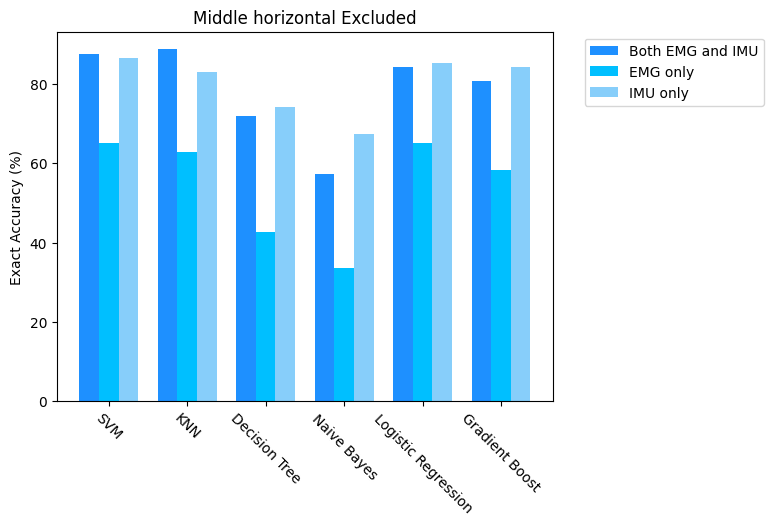

C:\Users\chloe\AppData\Local\Temp\ipykernel_36104\3280705851.py:34: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


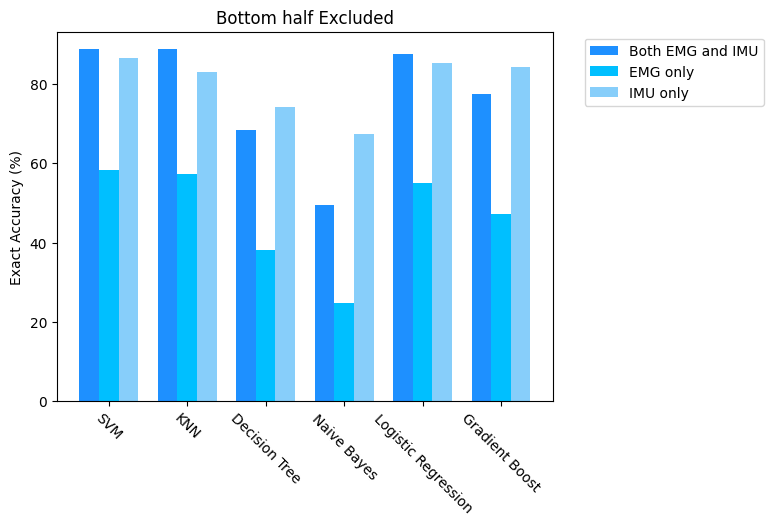

C:\Users\chloe\AppData\Local\Temp\ipykernel_36104\3280705851.py:34: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


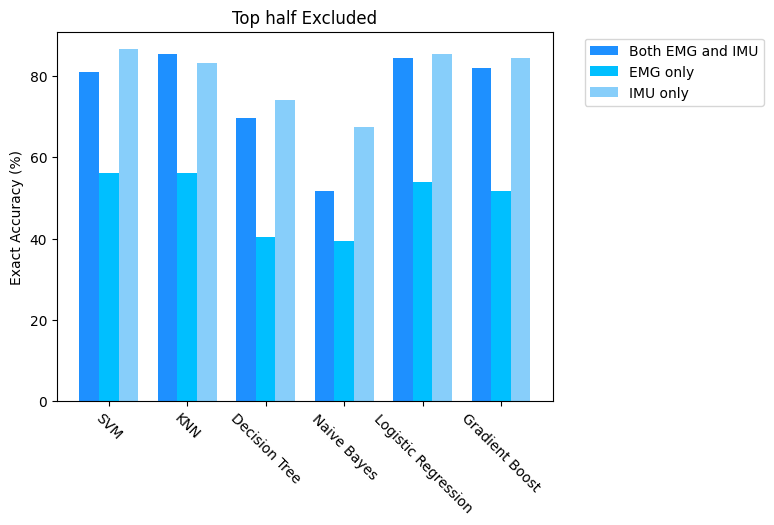

C:\Users\chloe\AppData\Local\Temp\ipykernel_36104\3280705851.py:34: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'] + exclude_channels)


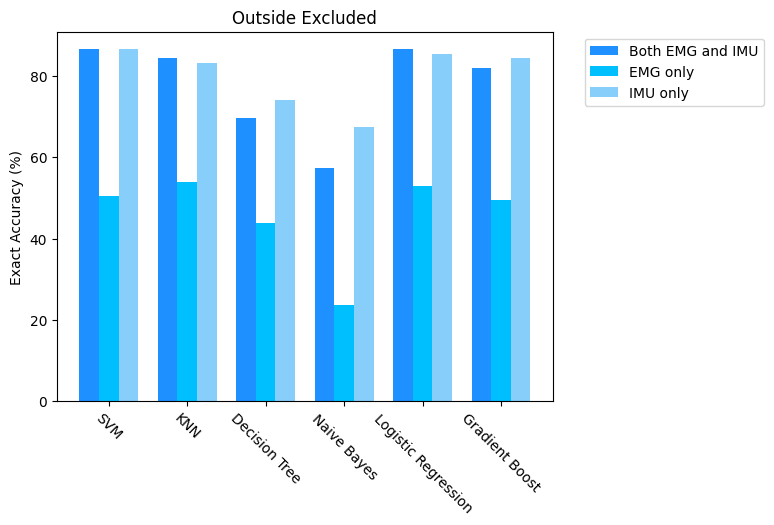

In [6]:
# EMG Channel configuration
# 9, 2, 4, 15
# 1, 12, 5, 7
# 10, 3, 14, 16
# 11, 13, 6, 8

configurations = [['None', []],
                  ['Corners', [9, 15, 11, 8]],
                  ['Top and bottom row', [9, 2, 4, 15, 11, 13, 6, 8]],
                  ['Right and left column', [9, 1, 10, 11, 15, 7, 16, 8]],
                  ['Middle vertical', [2, 4, 12, 5, 3, 14, 13, 6]],
                  ['Middle horizontal', [1, 12, 5, 7, 10, 3, 14, 16]],
                  ['Bottom half', [10, 3, 14, 16, 11, 13, 6, 8]],
                  ['Top half', [9, 2, 4, 15, 1, 12, 5, 7]],
                  ['Outside', [9, 2, 4, 15, 7, 16, 8, 6, 13, 11, 10, 1]]]

config_acc = []

for config in configurations:
    acc = configuration_models(config[0], config[1])
    acc_model_pairs = list(zip(acc, model_names))
    greatest_acc, model = max(acc_model_pairs, key=lambda x: x[0])
    config_acc.append([config[0], greatest_acc, model])

In [7]:
from matplotlib.colors import ListedColormap

emg_channels = {1: (1, 0),
                2: (0, 1),
                3: (2, 1),
                4: (0, 2),
                5: (1, 2),
                6: (3, 2),
                7: (1, 3),
                8: (3, 3),
                9: (0, 0),
                10: (2, 0),
                11: (3, 0),
                12: (1, 1),
                13: (3, 1),
                14: (2, 2),
                15: (0, 3),
                16: (2, 3)}

cmap = ListedColormap(['white', 'blue'])
save_dir = r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\notebooks\channel plots'

if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
os.makedirs(save_dir)  

for config in configurations:
    grid = np.full((4, 4), 1)
    
    exclude_coords = []
        
    exclude_channels = config[1]
        
    for channel in exclude_channels:
        exclude_coords.append(emg_channels[channel])
    
    for x, y in exclude_coords:
        grid[x, y] = 0
        
    plt.pcolor(grid, cmap=cmap, edgecolors='k', linewidths=1,vmin=0, vmax=1)
    plt.xticks([])  
    plt.yticks([])  
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal')
    
    save_path = os.path.join(save_dir, f'{config[0]}.png')
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()  

In [11]:
from IPython.display import HTML

os.chdir(r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\notebooks')

def path_to_img_html(path):
    return f'<img src="{path}" width="100" />'
    
config_acc = sorted(config_acc, key=lambda x: x[1], reverse=True)
sorted_acc = pd.DataFrame(config_acc, columns=['Channels Excluded', 'Highest Accuracy', 'Model'])

channel_plots = []
for config in sorted_acc['Channels Excluded']:
    file_path = (os.path.join(save_dir, f'{config}.png'))
    file_path = os.path.relpath(file_path, start=os.getcwd()).replace("\\", "/")
    channel_plots.append(file_path)

sorted_acc['Channel Plots'] = pd.Series(channel_plots).apply(path_to_img_html)

cols = list(sorted_acc.columns)          
cols.insert(0, cols.pop(cols.index('Channel Plots')))  
sorted_acc = sorted_acc[cols]  

HTML(sorted_acc.to_html(escape=False))

,Channel Plots,Channels Excluded,Highest Accuracy,Model
0,,Right and left column,92.134831,Logistic Regression
1,,None,88.764045,SVM
2,,Corners,88.764045,SVM
3,,Middle horizontal,88.764045,KNN
4,,Bottom half,88.764045,SVM
5,,Middle vertical,86.516854,KNN
6,,Outside,86.516854,SVM
7,,Top and bottom row,85.393258,SVM
8,,Top half,85.393258,KNN
